[View in Colaboratory](https://colab.research.google.com/github/thanhptse/DataScience/blob/master/HomeWork2/PredictingFraud.ipynb)

# **1. Data Understanding**

### **1.1 Import libary**

In [0]:
import pandas as pd
import io
from google.colab import files
import numpy as np
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score


### **1.2 Setup helper functions**

In [0]:
def get_countryname_by_ipaddress(ipAddress, df_ip2country):
  for index, row in df_ip2country.iterrows():
    if row['lower_bound_ip_address'] < ipAddress and ipAddress < row['upper_bound_ip_address']:
      return row['country']
  
  return ''

### **1.3 Load data**

In [64]:
uploaded = files.upload()

Saving Fraud_Data.csv to Fraud_Data (3).csv
Saving IpAddress_to_Country.csv to IpAddress_to_Country (2).csv


In [0]:
df_fraud = pd.read_csv(io.StringIO(uploaded['Fraud_Data.csv'].decode('utf-8')))
df_ip2country = pd.read_csv(io.StringIO(uploaded['IpAddress_to_Country.csv'].decode('utf-8')))

Rename column to easy understand

In [0]:
df_fraud.rename(index=str, columns={'class': 'isFraud'}, inplace=True)

### 1.4 Statistical summaries and visualisations

Take a look 2 data frame

In [67]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,isFraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [68]:
df_ip2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [0]:
# I want so map lower_bound_ip_address and upper_bound_ip_address to get country name in dataframe df_ip2country but it run too slow, dont know why
#df_ip2country_range = df_ip2country.groupby('country').agg({'lower_bound_ip_address':'min', 'upper_bound_ip_address':'max'})[['lower_bound_ip_address','upper_bound_ip_address']].reset_index()

Convert ip_address to country

In [0]:
# I want so map lower_bound_ip_address and upper_bound_ip_address to get country name in dataframe df_ip2country but it run too slow, dont know why
#df_fraud['country_name'] = df_fraud.apply (lambda row: get_countryname_by_ipaddress(row['ip_address'], df_ip2country_range),axis=1)
#df_fraud.head()

Check if there any missing values in DataFrame. It turns out there are no obvious missing values.

In [71]:
df_fraud.isnull().values.any()

False

In [72]:
df_ip2country.isnull().values.any()

False

Which type of browser  using to fraud?

In [73]:
print('\n The type of browser using to fraud are {}'.format(list(df_fraud.loc[df_fraud.isFraud == 1].browser.drop_duplicates().values)))

dfFraudOpera = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.browser == 'Opera')]
dfFraudIE = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.browser == 'IE')]
dfFraudFireFox = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.browser == 'FireFox')]
dfFraudChrome = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.browser == 'Chrome')]
dfFraudSafari = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.browser == 'Safari')]

print ('\n The number of fraudulent using browser IE = {}'.format(len(dfFraudIE))) 
print ('\n The number of fraudulent using browser FireFox = {}'.format(len(dfFraudFireFox))) 
print ('\n The number of fraudulent using browser Chrome = {}'.format(len(dfFraudChrome))) 
print ('\n The number of fraudulent using browser Safari = {}'.format(len(dfFraudSafari))) 


 The type of browser using to fraud are ['Opera', 'IE', 'FireFox', 'Chrome', 'Safari']

 The number of fraudulent using browser IE = 3187

 The number of fraudulent using browser FireFox = 2342

 The number of fraudulent using browser Chrome = 6069

 The number of fraudulent using browser Safari = 2225


Which type of sources using to fraud?

In [74]:
print('\n The type of source using to fraud are {}'.format(list(df_fraud.loc[df_fraud.isFraud == 1].source.drop_duplicates().values)))

dfFraudSEO = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.source == 'SEO')]
dfFraudDirect = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.source == 'Direct')]
dfFraudAds = df_fraud.loc[(df_fraud.isFraud == 1) & (df_fraud.source == 'Ads')]

print ('\n The number of fraudulent come from SEO = {}'.format(len(dfFraudSEO))) 
print ('\n The number of fraudulent come from Direct = {}'.format(len(dfFraudDirect))) 
print ('\n The number of fraudulent come from Ads = {}'.format(len(dfFraudAds))) 


 The type of source using to fraud are ['SEO', 'Direct', 'Ads']

 The number of fraudulent come from SEO = 5412

 The number of fraudulent come from Direct = 3226

 The number of fraudulent come from Ads = 5513


Min and Max amount of the activity was fraudulent

In [75]:
print('\nMin, Max value of the activity was fraudulent: {}'.format([round(df_fraud.purchase_value.min()), round(df_fraud.purchase_value.max())]))



Min, Max value of the activity was fraudulent: [9.0, 154.0]


# **2. Data Preparation**

**Before feature engineering**

In [76]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,isFraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


**Feature engineering**

In [77]:
df_fraud['isSEO'] = (df_fraud['source'] == 'SEO').astype(int)
df_fraud['isDirect'] = (df_fraud['source'] == 'Direct').astype(int)
df_fraud['isAds'] = (df_fraud['source'] == 'Ads').astype(int)

df_fraud['isOpera'] = (df_fraud['browser'] == 'Opera').astype(int)
df_fraud['isIE'] = (df_fraud['browser'] == 'IE').astype(int)
df_fraud['isFireFox'] = (df_fraud['browser'] == 'FireFox').astype(int)
df_fraud['isChrome'] = (df_fraud['browser'] == 'Chrome').astype(int)
df_fraud['isSafari'] = (df_fraud['browser'] == 'Safari').astype(int)

df_fraud["signup_time"] = pd.to_datetime(df_fraud["signup_time"]) 
df_fraud["year_signup_time"] = df_fraud["signup_time"].dt.year  
df_fraud["month_signup_time"] = df_fraud["signup_time"].dt.month

df_fraud["purchase_time"] = pd.to_datetime(df_fraud["purchase_time"]) 
df_fraud["year_purchase_time"] = df_fraud["purchase_time"].dt.year  
df_fraud["month_purchase_time"] = df_fraud["purchase_time"].dt.month

df_fraud['isMale'] = (df_fraud['sex'] == 'M').astype(int)
df_fraud['isFemale'] = (df_fraud['sex'] != 'M').astype(int)

cols_to_drop = ['source', 'browser', 'signup_time', 'purchase_time', 'user_id', 'device_id', 'sex', 'age', 'ip_address']
df_fraud.drop(cols_to_drop, axis=1, inplace=True)

df_fraud.head()

,purchase_value,isFraud,isSEO,isDirect,isAds,isOpera,isIE,isFireFox,isChrome,isSafari,year_signup_time,month_signup_time,year_purchase_time,month_purchase_time,isMale,isFemale
0,34,0,1,0,0,0,0,0,1,0,2015,2,2015,4,1,0
1,16,0,0,0,1,0,0,0,1,0,2015,6,2015,6,0,1
2,15,1,1,0,0,1,0,0,0,0,2015,1,2015,1,1,0
3,44,0,1,0,0,0,0,0,0,1,2015,4,2015,5,1,0
4,39,0,0,0,1,0,0,0,0,1,2015,7,2015,9,1,0


Text(0.5,1,u'Correlation between different fearures')

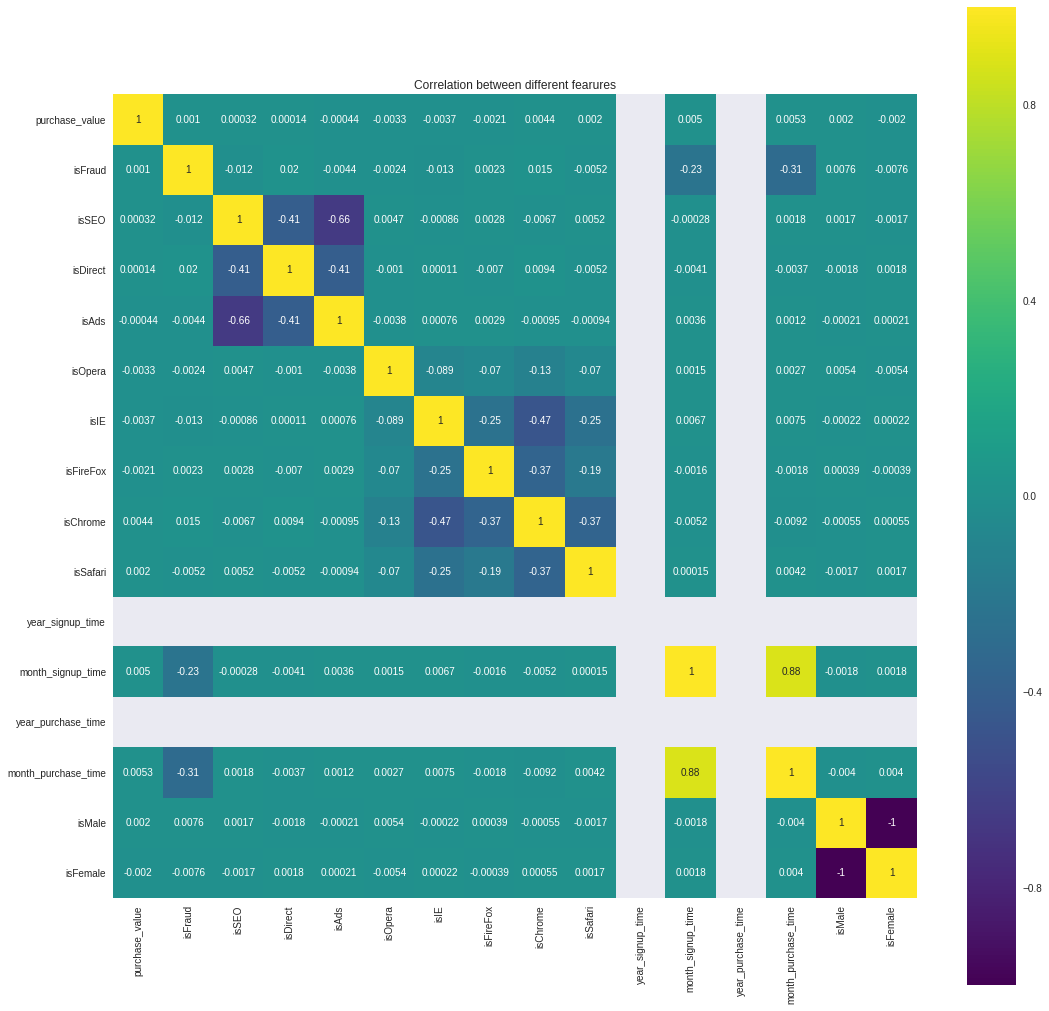

In [78]:
correlation = df_fraud.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')

# **3. Evaluation **

In [0]:
X = df_fraud.drop('isFraud', 1) # X without predict column
y = df_fraud['isFraud'] #predict column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


***GradientBoostingClassifier***

In [80]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

[[40437   680]
 [ 1895  2322]]
('Accuracy', 0.9431993647152248)


***Logistic Regression***

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pca = PCA()
logReg = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', logReg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('Accuracy', accuracy_score(y_test, y_pred))

[[41117     0]
 [ 4217     0]]
('Accuracy', 0.906979309127807)
